In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score

random.seed(42)

In [2]:
df = pd.read_csv('train.csv', index_col='id')

df.head()
df = df.dropna()

In [3]:
#ИСпользуем предобработку как для линейной регрессии
df.columns = df.columns.str.replace(' ', '_').str.lower() #Переименовываем колонки для более удобной работы

df['policy_start_date'] = pd.to_datetime(df['policy_start_date'])   #Преобразуем в формат даты
df['year'] = df['policy_start_date'].dt.year #Создаем числовую колонку с годом и месяцем
df['month'] = df['policy_start_date'].dt.month 

df['annual_income'] = np.log1p(df['annual_income']) #Логарифмируем чтобы приблизить к нормальному распределению


df['previous_claims'] = df['previous_claims'].dropna()

#Создаем новые фичи

df['claim_frequency'] = df['previous_claims'] / df['insurance_duration']
df['policy_ratio'] = df['insurance_duration'] / df['age']
df['credit_health'] = df['credit_score'] * df['health_score']
df['credit_health_interaction'] = df['credit_score'] * df['health_score']
df['claims_to_income_ratio'] = (df['previous_claims'] / df['annual_income']) * 10000
df['dependents_income'] = (df['number_of_dependents'] / df['annual_income']) * 10000



In [4]:
df.isna().sum()

age                          0
gender                       0
annual_income                0
marital_status               0
number_of_dependents         0
education_level              0
occupation                   0
health_score                 0
location                     0
policy_type                  0
previous_claims              0
vehicle_age                  0
credit_score                 0
insurance_duration           0
policy_start_date            0
customer_feedback            0
smoking_status               0
exercise_frequency           0
property_type                0
premium_amount               0
year                         0
month                        0
claim_frequency              0
policy_ratio                 0
credit_health                0
credit_health_interaction    0
claims_to_income_ratio       0
dependents_income            0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 384004 entries, 0 to 1199990
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   age                        384004 non-null  float64       
 1   gender                     384004 non-null  object        
 2   annual_income              384004 non-null  float64       
 3   marital_status             384004 non-null  object        
 4   number_of_dependents       384004 non-null  float64       
 5   education_level            384004 non-null  object        
 6   occupation                 384004 non-null  object        
 7   health_score               384004 non-null  float64       
 8   location                   384004 non-null  object        
 9   policy_type                384004 non-null  object        
 10  previous_claims            384004 non-null  float64       
 11  vehicle_age                384004 non-null  float64     

In [6]:
y = df['premium_amount']

# Разделение данных на обучающую и тестовую выборки с сохранением распределения
train_df, test_df, train_target, test_target = train_test_split(df, y, test_size=0.9, random_state=42)

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38400 entries, 99874 to 381275
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   age                        38400 non-null  float64       
 1   gender                     38400 non-null  object        
 2   annual_income              38400 non-null  float64       
 3   marital_status             38400 non-null  object        
 4   number_of_dependents       38400 non-null  float64       
 5   education_level            38400 non-null  object        
 6   occupation                 38400 non-null  object        
 7   health_score               38400 non-null  float64       
 8   location                   38400 non-null  object        
 9   policy_type                38400 non-null  object        
 10  previous_claims            38400 non-null  float64       
 11  vehicle_age                38400 non-null  float64       
 12  cred

In [8]:
#Строим модель

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer

#Столбцы Education Level и Policy Type кодируем Ordinal Encoder (есть порядок)
#Gender Marital Status, Location через one hot (небольшое количество уникальных)

numerical_features = df.select_dtypes(include=np.number).columns.to_list()
numerical_features.remove('premium_amount')
onehot_features = ['marital_status', 'gender', 'smoking_status', 'property_type']
education_features = ['education_level']
policy_feature = ['policy_type']
feedback_feature = ['customer_feedback']
exercise_feature = ['exercise_frequency']
location_feature = ['location']

# Трансформер для категориальных признаков с OneHotEncoder
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Трансформеры для категориальных признаков с OrdinalEncoder
education_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[["Bachelor's", 'High School', "Master's", 'PhD']]))
])

feedback_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Poor', 'Average', 'Good']])) 
])

exercise_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Rarely', 'Monthly', 'Weekly', 'Daily']])) 
])

policy_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Basic', 'Comprehensive', 'Premium']]))
])

location_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(categories=[['Rural', 'Suburban', 'Urban']]))
])


numeric_transforms = [
    ('imputer', SimpleImputer(strategy='median')),
]

num_transformer = Pipeline(steps=numeric_transforms)

feature_preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features),
        ('onehot', onehot_transformer, onehot_features),
        ('education', education_transformer, education_features),
        ('policy', policy_transformer, policy_feature),
        ('feedback', feedback_transformer, feedback_feature),
        ('exrcise', exercise_transformer, exercise_feature),
        ('location', location_transformer, location_feature)
    ])

dec_tree_regr_m = Pipeline(steps=[
    ('preprocessor', feature_preprocessor),
    ('regression', DecisionTreeRegressor())
])


In [ ]:
#Обучаем модель
y_train = train_target
X_train = train_df[numerical_features + onehot_features + education_features + policy_feature + feedback_feature + exercise_feature + location_feature]

dec_tree_regr_m.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'annual_income',
                                                   'number_of_dependents',
                                                   'health_score',
                                                   'previous_claims',
                                                   'vehicle_age',
                                                   'credit_score',
                                                   'insurance_duration', 'year',
                                                   'month', 'claim_frequency',
                                                   'policy_ratio',
                                                   'credit_health',
                                                   'credit_health_interact...
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rarely',
                                                                                               'Monthly',
                                                                                               'Weekly',
                                                                                               'Daily']]))]),
                                                  ['exercise_frequency']),
                                                 ('location',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rural',
                                                                                               'Suburban',
                                                                                               'Urban']]))]),
                                                  ['location'])])),
                ('regression', DecisionTreeRegressor())])

In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error 

def print_score(model_name, funcs, y, y_pred):
    print(f'Score for {model_name}')
    for func in funcs:
        print(f'{func.__name__}: {func(y, y_pred):.4f}')
    print()

predict = dec_tree_regr_m.predict(test_df)


print_score('Dec tree регрессия', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score], test_target, predict)

Score for Dec tree регрессия
mean_absolute_error: 897.6690
mean_squared_error: 1521322.0032
mean_absolute_percentage_error: 3.4663
r2_score: -1.0167



In [ ]:
#Находим лучшие гиперпараметры при помощи hyperopt
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

space = {
    'criterion': hp.choice('criterion', ['friedman_mse', 'squared_error', 'absolute_error', 'poisson']),
    'max_depth': hp.randint('max_depth', 2, 30),
    'min_samples_split': hp.randint('min_samples_split', 2, 10),
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 5),
    'max_features': hp.choice('max_features', [None, 'sqrt', 'log2']),
}

def objective(params):

    regressor = DecisionTreeRegressor(
        criterion=params['criterion'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        min_samples_leaf=params['min_samples_leaf'],
        max_features=params['max_features'],
    )
    
    model = Pipeline(steps=[
        ('preprocessor', feature_preprocessor),
        ('regression', regressor)
    ])


    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    mean_score = np.mean(scores) #Усредняем оценку по разбивкам
    return {'loss': -mean_score, 'status': STATUS_OK}    

trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print(f'best params: {best}')

100%|██████████| 10/10 [01:20<00:00,  8.07s/trial, best loss: -0.044981630297235474]
best params: {'criterion': np.int64(3), 'max_depth': np.int64(5), 'max_features': np.int64(0), 'min_samples_leaf': np.int64(2), 'min_samples_split': np.int64(2)}


In [ ]:
#Создаем и обучаем модель с лучшими гиперпараметрами
best['criterion'] = ['friedman_mse', 'squared_error', 'absolute_error', 'poisson'][best['criterion']]
best['max_features'] = None



dec_tree_regr_m = Pipeline(steps=[
    ('preprocessor', feature_preprocessor),
    ('regression', DecisionTreeRegressor(**best))
])

dec_tree_regr_m.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'annual_income',
                                                   'number_of_dependents',
                                                   'health_score',
                                                   'previous_claims',
                                                   'vehicle_age',
                                                   'credit_score',
                                                   'insurance_duration', 'year',
                                                   'month', 'claim_frequency',
                                                   'policy_ratio',
                                                   'credit_health',
                                                   'credit_health_interact...
                                                                                               'Weekly',
                                                                                               'Daily']]))]),
                                                  ['exercise_frequency']),
                                                 ('location',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(categories=[['Rural',
                                                                                               'Suburban',
                                                                                               'Urban']]))]),
                                                  ['location'])])),
                ('regression',
                 DecisionTreeRegressor(criterion='poisson',
                                       max_depth=np.int64(5),
                                       min_samples_leaf=np.int64(2),
                                       min_samples_split=np.int64(2)))])

In [ ]:
#Делаем предикт на тестовых данных
X_test = test_df[numerical_features + onehot_features + education_features + policy_feature + feedback_feature + exercise_feature + location_feature]
y_test = test_target

y_predict = dec_tree_regr_m.predict(X_test)

print_score('dec tree регрессия best', [mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score], y_test, y_predict)


Score for dec tree регрессия best
mean_absolute_error: 639.2567
mean_squared_error: 718233.3944
mean_absolute_percentage_error: 3.0816
r2_score: 0.0479



Лучшая модель до этого была SVR с результатом 

Score for SVR регрессия best
mean_absolute_error: 641.1794
mean_squared_error: 803669.4490
mean_absolute_percentage_error: 2.3658
r2_score: -0.0653

В модели decision tree regressor лучше параметры MAE, MSE и R2 но несколько выше параметр MAPE

mean_absolute_error: 639.2567
mean_squared_error: 718233.3944
mean_absolute_percentage_error: 3.0816
r2_score: 0.0479

обе модели используют одинаковый препроцессинг за исключением нормализации данных для модели на базе дерева решений.

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30],
 [Text(0, 0, 'num__credit_score'),
  Text(1, 0, 'num__year'),
  Text(2, 0, 'num__health_score'),
  Text(3, 0, 'num__annual_income'),
  Text(4, 0, 'num__claims_to_income_ratio'),
  Text(5, 0, 'num__policy_ratio'),
  Text(6, 0, 'num__age'),
  Text(7, 0, 'num__dependents_income'),
  Text(8, 0, 'num__credit_health_interaction'),
  Text(9, 0, 'num__month'),
  Text(10, 0, 'num__number_of_dependents'),
  Text(11, 0, 'num__vehicle_age'),
  Text(12, 0, 'num__insurance_duration'),
  Text(13, 0, 'num__claim_frequency'),
  Text(14, 0, 'num__previous_claims'),
  Text(15, 0, 'num__credit_health'),
  Text(16, 0, 'onehot__marital_status_Divorced'),
  Text(17, 0, 'onehot__marital_status_Married'),
  Text(18, 0, 'onehot__marital_status_Single'),
  Text(19, 0, 'onehot__gender_Female'),
  Text(20, 0, 'onehot__gender_Male'),
  Text(

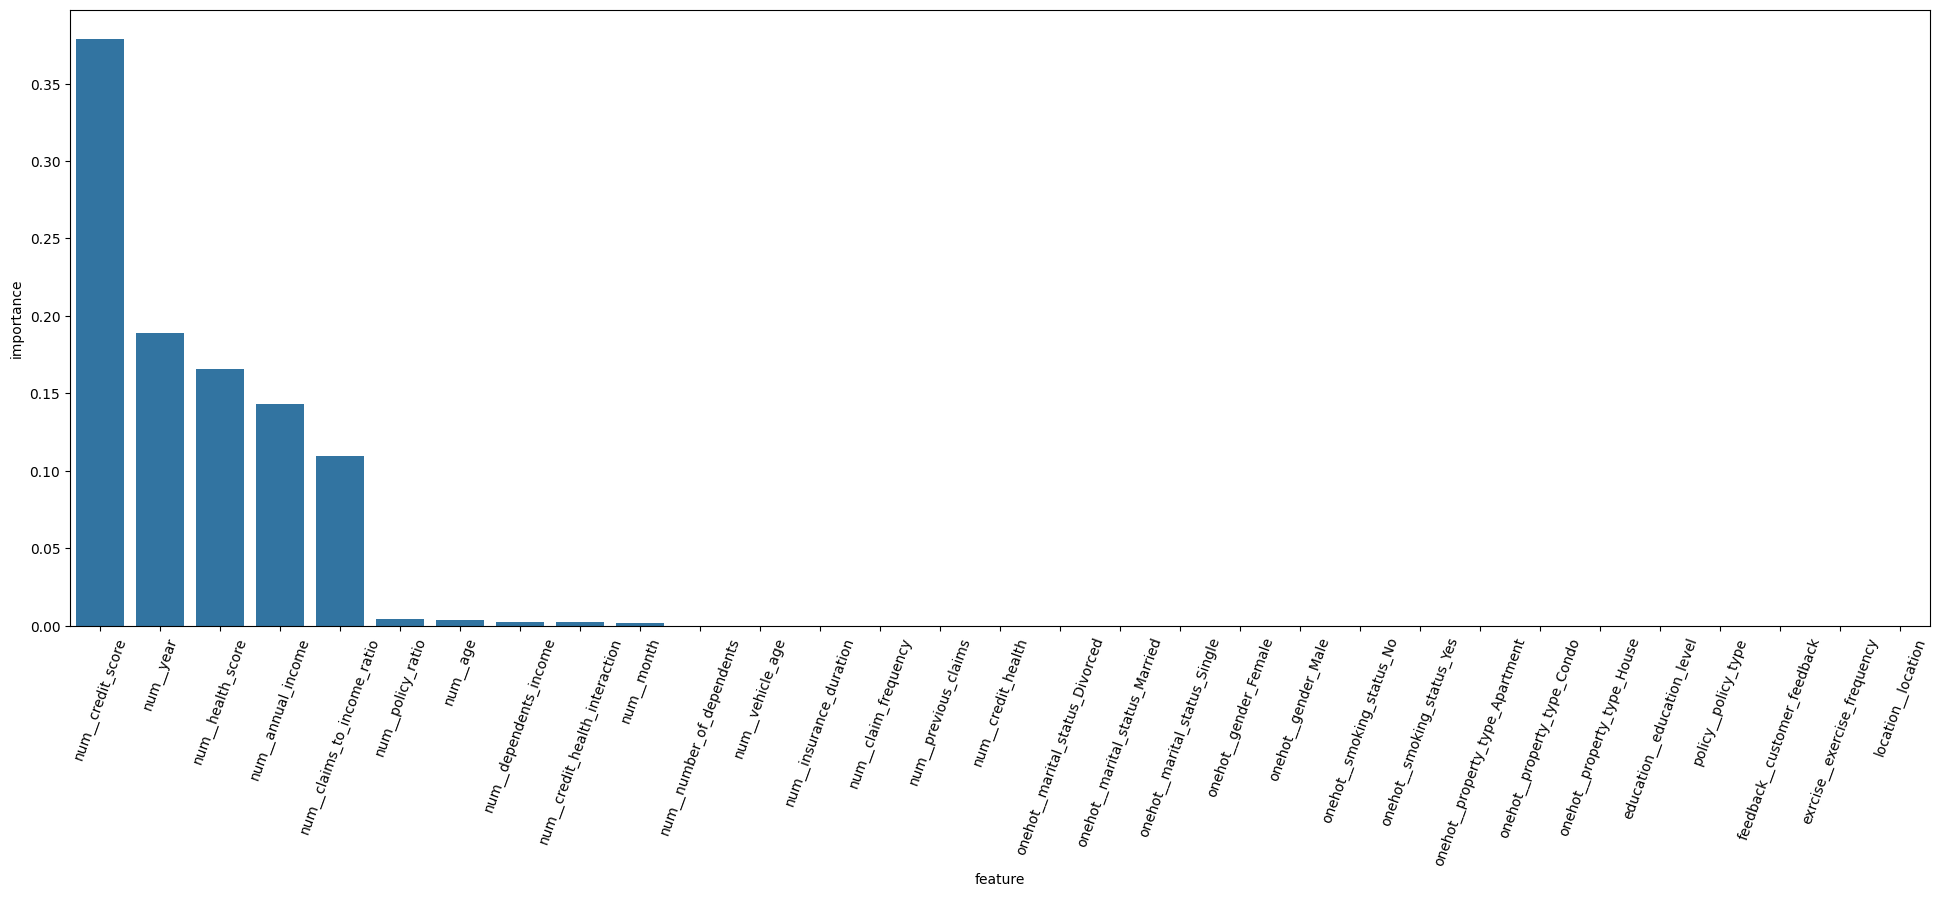

In [ ]:
#Определяем важность фичей модели
feature_importance_df = pd.DataFrame({
    'feature': dec_tree_regr_m.named_steps['preprocessor'].get_feature_names_out(),
    'importance': dec_tree_regr_m.named_steps['regression'].feature_importances_
})

feature_importance_df = feature_importance_df.sort_values(['importance'], ascending=False)

plt.figure(figsize=(24, 8))
sns.barplot(data = feature_importance_df, x='feature', y='importance')
plt.xticks(rotation=70)